In [1]:
# ! pip install -e ../../savo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy as copy
from scipy import optimize
import torch
np.random.seed(479)
torch.random.manual_seed(971)

import sys
sys.path.append('../')
sys.path.append('../../machineIO/')
from savo import savo
from savo.optim import adam
from machineIO.util import plot_2D_projection, dictClass
from machineIO.objFunc import SingleTaskObjectiveFunction
from machineIO.VM import VirtualMachineIO
from machineIO import Evaluator

Failed to import 'epics'
Failed to import 'phantasy'


In [3]:
ndim = 50
budget = 200
ninit = ndim  # number of initial ES steps to collect data for surrogate model training
noise = 1e-2
max_dx = 2e-2
lr = 1e-2

In [4]:
control_CSETs = [f'X{i}:I_CSET' for i in range(ndim)]
control_RDs   = [f'X{i}:I_RD'   for i in range(ndim)]
control_min   = -np.ones(ndim)
control_max   =  np.ones(ndim)
control_maxstep = max_dx*np.ones(ndim)
control_tols  = 1e-3*(control_max-control_min)
monitor_RDs   = [f'Y{i}:I_RD' for i in range(2)]
monitor_min   = -2*np.ones(2)
monitor_max   =  2*np.ones(2)

objective_PVs = monitor_RDs
composite_objective_name = 'rastrigin'

In [5]:
vmio = VirtualMachineIO(
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    monitor_RDs = monitor_RDs,
    control_min = control_min,
    control_max = control_max,
    monitor_min = monitor_min,
    monitor_max = monitor_max,
    fetch_data_time_span = 1.0
)

# obj_func

: rastirigin over 2D latent space of random NN for both high-dim and visualization

In [6]:
def rastrigin(x, noise=0.0):
    x = torch.as_tensor(x)
    d = x.shape[-1]
    y = torch.sum(x**2 - torch.cos(2*np.pi*x), dim=-1) / d + 1
    return 1 - y + torch.randn_like(y) * noise

In [7]:
# random initial point far from optimum
y = 1
while y>0:
    control_init = np.random.rand(ndim)*(control_max-control_min)+control_min
    vmio.x = control_init
    ret, df = vmio.get_df(monitor_RDs)
    y = rastrigin(df.values).mean()

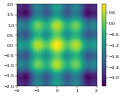

In [8]:
grid = np.linspace(-2,2,128)
x1,x2 = np.meshgrid(grid,grid)
xgrid = np.vstack((x1.flatten(), x2.flatten())).T
ygrid = rastrigin(xgrid,noise=0)
def plot_contour(fig,ax):
    cs = ax.tricontourf(xgrid[:,0],xgrid[:,1],ygrid,levels=32)
    fig.colorbar(cs,ax=ax)
fig,ax = plt.subplots(figsize=(4,3.3),dpi=32)
plot_contour(fig,ax)

In [9]:
obj_func = SingleTaskObjectiveFunction(
    objective_PVs = monitor_RDs,
    composite_objective_name = composite_objective_name,
    custom_function = rastrigin,
    objective_goal = None, 
    objective_weight = None,
    objective_tolerance = None,
)

In [10]:
evaluator = Evaluator(
    machineIO = vmio,
    control_CSETs = control_CSETs,
    control_RDs = control_RDs,
    control_tols = control_tols,
    monitor_RDs = monitor_RDs,
    df_manipulators = [obj_func.calculate_objectives_from_df],
)

In [11]:
def plot_hist(history,eval_hist_mean):
    fig, ax = plt.subplots(1,3,figsize=(11,3),dpi=96)
    xaxis = np.arange(len(history['y']))
    ax[0].plot(xaxis, history['y'])
    ax[0].set_xlabel('epoch');
    ax[0].set_ylabel('objective');
    ax[1].plot(xaxis, history['cpu_time'])
    ax[1].set_xlabel('epoch');
    ax[1].set_ylabel('cpu_time');
    plot_contour(fig,ax[2])
    ax[2].plot(eval_hist_mean['Y0:I_RD'],eval_hist_mean['Y1:I_RD'],'k',lw=1)
    start_x = eval_hist_mean['Y0:I_RD'][0]
    start_y = eval_hist_mean['Y1:I_RD'][0]
    end_x = eval_hist_mean['Y0:I_RD'][-1]
    end_y = eval_hist_mean['Y1:I_RD'][-1]
    ax[2].plot(start_x, start_y, 'g+', markersize=4, label='Start Point') # 'go' for green circle
    ax[2].plot(end_x, end_y, 'r*', markersize=4, label='End Point') # 'rs' for red square
    ax[2].set_xlabel('Y0:I_RD')
    ax[2].set_ylabel('Y1:I_RD')
    ax[2].set_title('Latent Objetive Path')
    ax[2].legend() # Show the labels
    fig.tight_layout()

# ES

In [12]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator,
          obj_func=obj_func)
for i in range(budget):
    sv.step(lr=0,lrES=1)

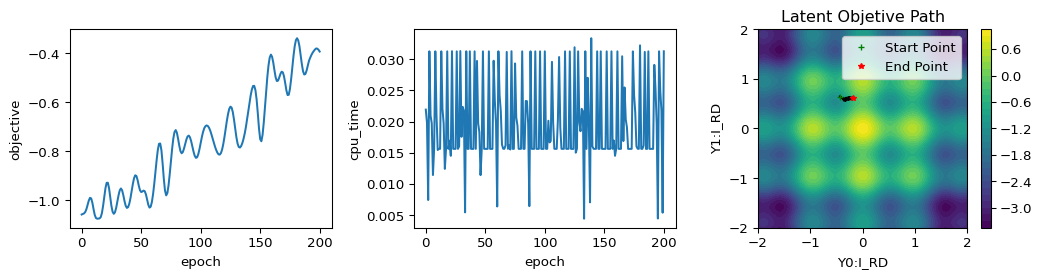

In [13]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

# ES + adamSG

In [14]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
optimizer = adam()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, 
          optimizer=optimizer, obj_func=obj_func)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=1,lrES=1)

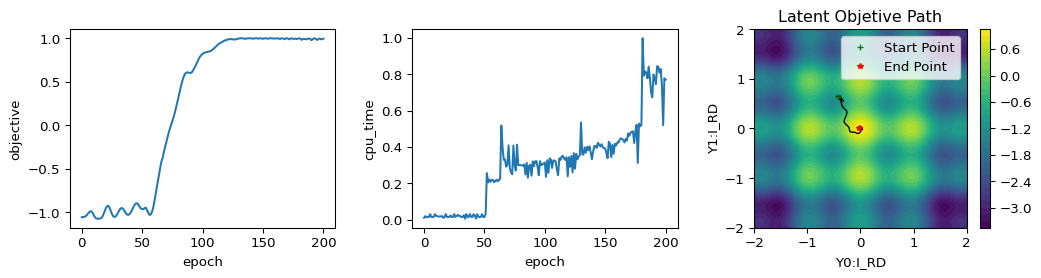

In [15]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

# ES + SG

In [16]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator,
          obj_func=obj_func)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=1,lrES=1)

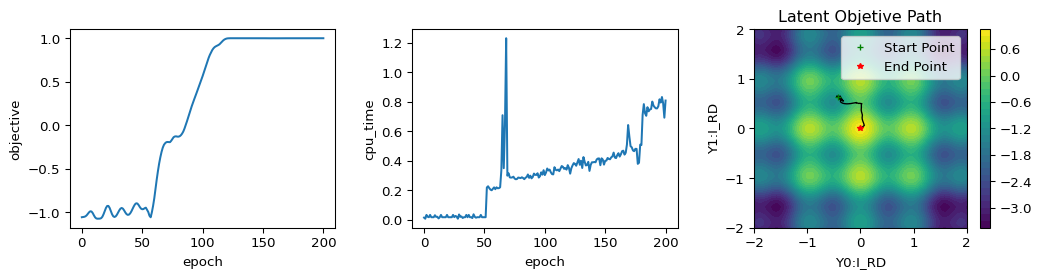

In [17]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

# SG wo ES

In [18]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator,
          obj_func=obj_func)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=1,lrES=0)

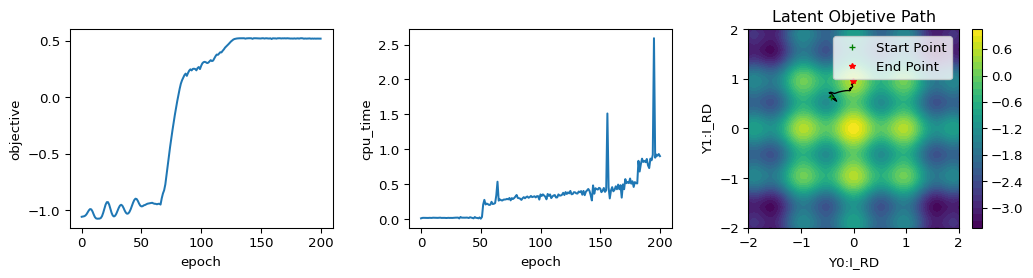

In [19]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])

# adamSG wo ES

In [20]:
df,ramp = evaluator._set_and_read(control_init)
evaluator.clear_history()
optimizer = adam()
sv = savo(control_CSETs, control_RDs, control_min, control_max, control_maxstep, objective_PVs, composite_objective_name, evaluator, optimizer=optimizer,
          obj_func=obj_func)
for i in range(ninit):
    sv.step(lr=0,lrES=1)
for i in range(budget-ninit):
    sv.step(lr=1,lrES=0)

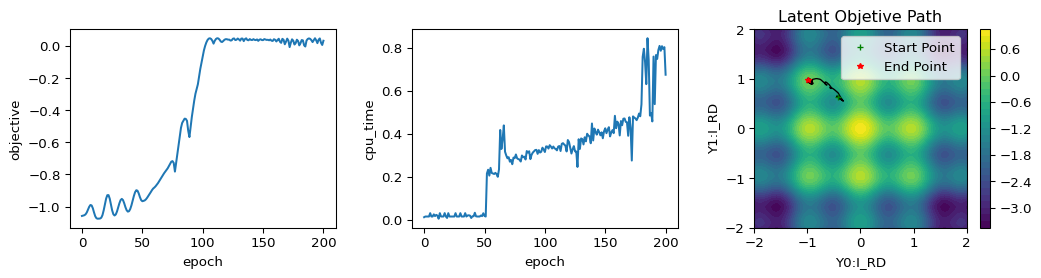

In [21]:
plot_hist(sv.history,sv.evaluator.get_history()['mean'])